In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((256, 256))
image_size = 0
train_root = "C:/Users/biyya/min prjct/final/sized"
valid_root = "C:/Users/biyya/min prjct/final/valid"
test_root = "C:/Users/biyya/min prjct/final/test"
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
#train
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(train_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for disease_folder in root_dir :
        plant_disease_image_list = listdir(f"{train_root}/{disease_folder}")
        
        for image in plant_disease_image_list:
            image_directory = f"{train_root}/{disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [5]:
#valid
v_image_list, v_label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(valid_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for disease_folder in root_dir :
        plant_disease_image_list = listdir(f"{valid_root}/{disease_folder}")
        
        for image in plant_disease_image_list:
            image_directory = f"{valid_root}/{disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                v_image_list.append(convert_image_to_array(image_directory))
                v_label_list.append(disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)
print("Train Images : ",image_size)

Train Images :  4000


In [7]:
v_image_size = len(v_image_list)
print("Valid Images : ",v_image_size)

Valid Images :  1200


In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
v_label_binarizer = LabelBinarizer()
v_image_labels = v_label_binarizer.fit_transform(v_label_list)
pickle.dump(v_label_binarizer,open('v_label_transform.pkl', 'wb'))
v_n_classes = len(v_label_binarizer.classes_)

In [10]:
print(label_binarizer.classes_)
print(v_label_binarizer.classes_)


['Bacterialblight' 'Blast' 'Brownspot' 'Healthy']
['Bacterialblight' 'Blast' 'Brownspot' 'Healthy']


In [11]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [12]:
v_np_image_list = np.array(v_image_list, dtype=np.float16) / 225.0

In [13]:
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [14]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [16]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [17]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_5conv2dense_woutBG.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto') 

In [18]:
history = model.fit(
    aug.flow(np_image_list, image_labels, batch_size=BS),
    validation_data=aug.flow(v_np_image_list, v_image_labels, batch_size=BS),
    steps_per_epoch=len(np_image_list) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=[checkpoint]
    )

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.7673
Epoch 1: val_accuracy improved from -inf to 0.25250, saving model to best_model_5conv2dense_woutBG.h5
250/250 [==============================] - 716s 3s/step - loss: 0.3740 - accuracy: 0.7673 - val_loss: 1.3197 - val_accuracy: 0.2525
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.8298
Epoch 2: val_accuracy improved from 0.25250 to 0.82000, saving model to best_model_5conv2dense_woutBG.h5
250/250 [==============================] - 685s 3s/step - loss: 0.2348 - accuracy: 0.8298 - val_loss: 0.2072 - val_accuracy: 0.8200
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.8457
Epoch 3: val_accuracy did not improve from 0.82000
250/250 [==============================] - 673s 3s/step - loss: 0.2055 - accuracy: 0.8457 - val_loss: 0.3673 - val_accuracy: 0.7875
Epoch 4/20
250/250 [==============================] - ETA:

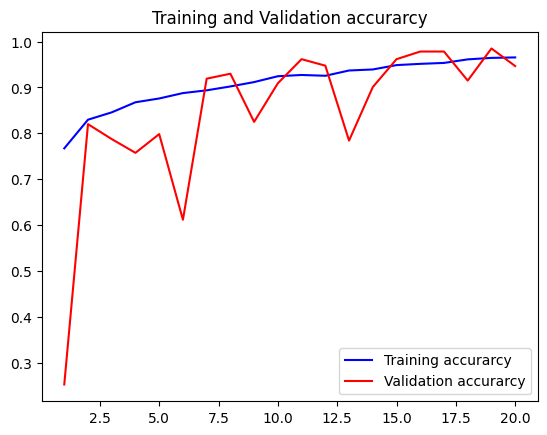

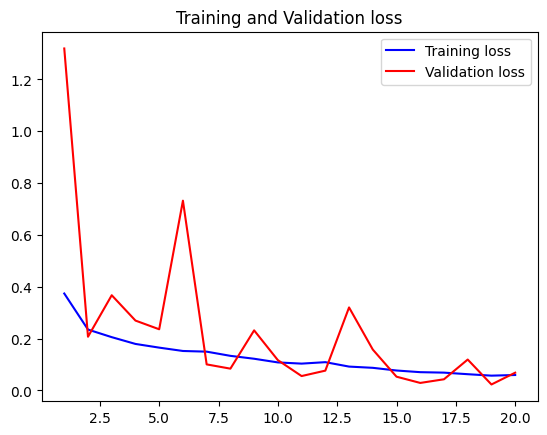

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [21]:
from keras.models import load_model
loaded_model = load_model('best_model_5conv2dense_woutBG.h5')
loaded_model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])

# load weights into new model
loaded_model.load_weights("best_model_5conv2dense_woutBG.h5")

In [20]:
import cv2
import os
# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (256, 256) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return probabilities

1/1 [==============================] - 1s 566ms/step
Bacterialblight  :  2.2821623e-05
Blast  :  1.5179689e-05
Brownspot  :  0.9999621
Healthy  :  1.4269092e-08


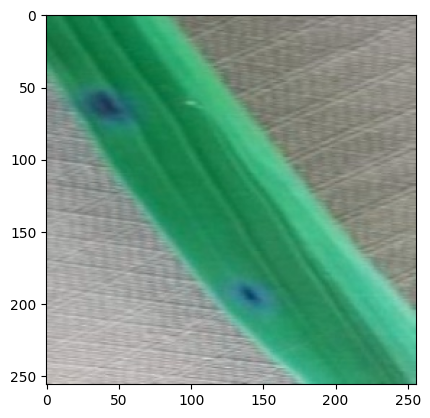

In [21]:
filename="C:/Users/biyya/min prjct/final/test/Brownspot/BROWNSPOT6_153.jpg"
img = load_image(filename)
prediction = predict(img)
for i in range(len(prediction)):
    print(label_binarizer.classes_[i]," : ",prediction[i])
# print("PREDICTED: class: " , (prediction))
print
plt.imshow(img)
# plt.figure(idx)    
plt.show()

1/1 [==============================] - 0s 100ms/step
Bacterialblight  :  0.9999846
Blast  :  9.82526e-06
Brownspot  :  5.2289465e-06
Healthy  :  3.1337285e-07


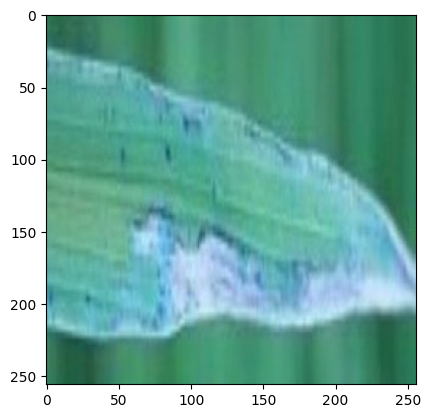

In [22]:
filename="C:/Users/biyya/min prjct/final/test/Bacterialblight/BACTERIALBLIGHT1_249.jpg"
img = load_image(filename)
prediction = predict(img)
for i in range(len(prediction)):
    print(label_binarizer.classes_[i]," : ",prediction[i])
# print("PREDICTED: class: " , (prediction))
print
plt.imshow(img)
# plt.figure(idx)    
plt.show()

1/1 [==============================] - 0s 73ms/step
Bacterialblight  :  0.0010957514
Blast  :  0.8044172
Brownspot  :  0.19447593
Healthy  :  1.1155745e-05


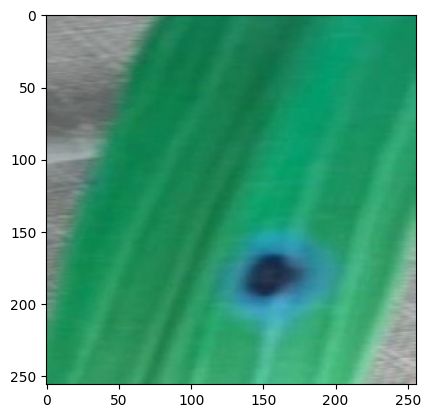

In [23]:
filename="C:/Users/biyya/min prjct/final/test/Brownspot/BROWNSPOT6_127.jpg"
img = load_image(filename)
prediction = predict(img)
for i in range(len(prediction)):
    print(label_binarizer.classes_[i]," : ",prediction[i])
# print("PREDICTED: class: " , (prediction))
print
plt.imshow(img)
# plt.figure(idx)    
plt.show()

1/1 [==============================] - 0s 77ms/step
Bacterialblight  :  1.5171668e-05
Blast  :  0.22544517
Brownspot  :  0.77452105
Healthy  :  1.8656594e-05


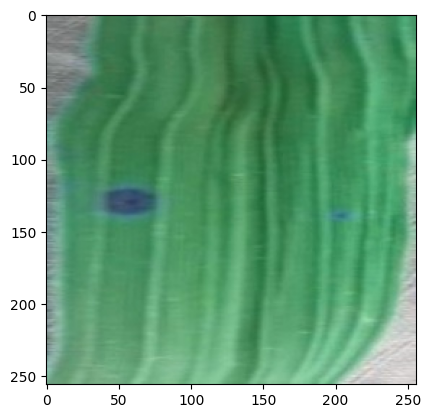

In [24]:
filename="C:/Users/biyya/min prjct/final/test/Brownspot/BROWNSPOT7_085.jpg"
img = load_image(filename)
prediction = predict(img)
for i in range(len(prediction)):
    print(label_binarizer.classes_[i]," : ",prediction[i])
# print("PREDICTED: class: " , (prediction))
print
plt.imshow(img)
# plt.figure(idx)    
plt.show()

1/1 [==============================] - 0s 55ms/step
Bacterialblight  :  3.1612367e-06
Blast  :  0.9999882
Brownspot  :  8.535241e-06
Healthy  :  6.024043e-08


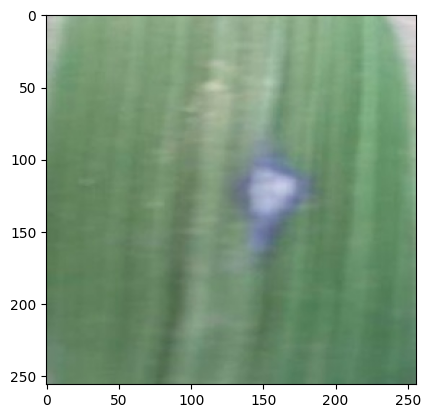

In [25]:
filename="C:/Users/biyya/min prjct/final/test/Blast/BLAST9_097.jpg"
img = load_image(filename)
prediction = predict(img)
for i in range(len(prediction)):
    print(label_binarizer.classes_[i]," : ",prediction[i])
# print("PREDICTED: class: " , (prediction))
print
plt.imshow(img)
# plt.figure(idx)    
plt.show()

1/1 [==============================] - 0s 48ms/step
Bacterialblight  :  2.5428514e-20
Blast  :  6.6106857e-22
Brownspot  :  6.487605e-20
Healthy  :  1.0


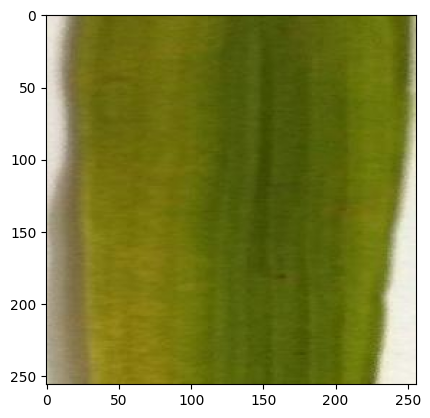

In [26]:
filename="C:/Users/biyya/min prjct/final/test/Healthy/IMG_20190420_193240.jpg"
img = load_image(filename)
prediction = predict(img)
for i in range(len(prediction)):
    print(label_binarizer.classes_[i]," : ",prediction[i])
# print("PREDICTED: class: " , (prediction))
print
plt.imshow(img)
# plt.figure(idx)    
plt.show()